In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Import the necessary libraries first

'''import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
import cv2
import shutil
import glob'''

'import tensorflow as tf\nimport os\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n%matplotlib inline\nfrom tensorflow.keras.preprocessing import image\nfrom keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array\nfrom tensorflow.keras.metrics import categorical_crossentropy\nfrom keras.models import Sequential, Model\nfrom keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D\nfrom keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D\nfrom keras.models import Sequential, Model\nfrom tensorflow.keras.optimizers import Adam, SGD, RMSprop\nfrom keras import backend as K\nimport cv2\nimport shutil\nimport glob'

In [3]:
import os
import pandas as pd

import xml.etree.ElementTree as ET
#import gdown
import time
import math
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.utils import np_utils
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from sklearn.metrics import classification_report

from PIL import Image
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
print("Loaded all libraries")

Loaded all libraries


In [4]:
image_path = '/content/drive/MyDrive/ADA_Project/data/'
num_of_categories = 2
image_size = 299
batch_size = 16

In [5]:
import time
floor_list = sorted(os.listdir(image_path))

num_classes = len(floor_list)
print("{} floor_classes".format(num_classes))

2 floor_classes


In [6]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [7]:
%cd /content/drive/MyDrive/ADA_Project/

/content/drive/MyDrive/ADA_Project


In [ ]:
'''os.mkdir('data')
for floor in floor_list:
    os.mkdir('data/' + floor)
print('Created {} folders to store cropped images of the different floor classes.'.format(len(os.listdir('data'))))



In [8]:
!ls

data	       floor_incept_weights.h5	  my_model_inception.h5  test_1.jpg
data1	       floor_resnet50_weights.h5  my_model_resnet50.h5
data_aug       inception_resnet_plot.png  test
Floor_dataset  model.png		  test1


In [9]:
%cd data

/content/drive/MyDrive/ADA_Project/data


In [10]:
!ls

clean  dirty


In [11]:
%cd ..

/content/drive/MyDrive/ADA_Project


In [12]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(floor_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [13]:
!ls

data	       floor_incept_weights.h5	  my_model_inception.h5  test_1.jpg
data1	       floor_resnet50_weights.h5  my_model_resnet50.h5
data_aug       inception_resnet_plot.png  test
Floor_dataset  model.png		  test1


In [14]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in floor_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

In [15]:
class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = cv2.imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.Sometimes(0.5,
                    
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-40, 40),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

In [16]:
x_train, x_test, y_train, y_test = train_test_split(paths, targets, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

train_ds = ImageGenerator(x_train, y_train, batch_size=32, shape=(image_size, image_size,3), augment=True)
val_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)
test_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)

In [17]:
#base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg')#Summary of Xception Model

#base_model.trainable = False


#pre_trained_model.summary()

#from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

#resnet_model = ResNet50V2(input_shape = [image_size,image_size,3], weights='imagenet', include_top=False)
#base_model.trainable = False





from tensorflow.keras.applications import InceptionResNetV2

base_model = InceptionResNetV2(input_shape = [image_size,image_size,3],weights='imagenet',include_top=False,pooling='None')

#pre_trained_model.summary()

In [18]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [19]:


from tensorflow.keras.layers import BatchNormalization

In [20]:
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
#add fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

In [21]:
from tensorflow.keras.models import load_model, Model
predictions = Dense(2, activation='softmax')(x)
 
#create model class with inputs and outputs
my_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
'''flat_dim = 5 * 5* 1536

my_model = Sequential(base_model)

#my_model.add(Flatten())
#my_model.add(Dropout(0.1)) # dropout added
my_model.add(Dense(1032, activation='relu',input_dim=flat_dim))
my_model.add(Dense(512, activation='relu'))
#my_model.add(Dropout(0.1))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dense(2, activation='softmax'))



In [22]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

[1e-05, 6.505114555849587e-06, 1.3998974074878144e-05, 2.1158257692363077e-05, 2.6349806140466085e-05, 2.9032781503571898e-05, 2.9396559030789573e-05, 2.7979491786027585e-05, 2.540182222438155e-05, 2.2217993076484613e-05, 1.885603456913674e-05, 1.5609303737669377e-05, 1.265427690063973e-05, 1.0077640616334645e-05, 7.903437440340427e-06, 6.116030942221757e-06, 4.677609611772819e-06, 3.5404805065519026e-06, 2.655051675737932e-06, 1.9745568653868732e-06, 1.457488127964179e-06, 1.068520029068309e-06, 7.785125464502897e-07, 5.640054703120814e-07, 4.0647805168961314e-07]


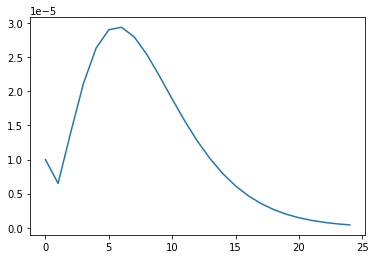

In [23]:
###################
total_epoch = 8
learning_rate_init = 0.00001
###################

def lr_scheduler(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 40:
        return (0.2*epoch**3)*math.exp(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(40-1)
    

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [24]:
# Callbacks

scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience = 3, mode='max', min_delta=1, verbose=1)

In [26]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
process_time_starts()
hist = my_model.fit_generator(generator=train_ds, steps_per_epoch=20, validation_data=val_ds,  validation_steps=10, epochs=8, callbacks=[scheduler])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/8
20/20 [==============================] - 1240s 61s/step - loss: 0.7085 - accuracy: 0.5828 - val_loss: 0.5975 - val_accuracy: 0.7125 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 6.505114555849587e-06.
Epoch 2/8
20/20 [==============================] - 1209s 61s/step - loss: 0.6702 - accuracy: 0.6234 - val_loss: 0.5443 - val_accuracy: 0.7594 - lr: 6.5051e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.3998974074878144e-05.
Epoch 3/8
20/20 [==============================] - 1195s 60s/step - loss: 0.5313 - accuracy: 0.7402 - val_loss: 0.4587 - val_accuracy: 0.7906 - lr: 1.3999e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.1158257692363077e-05.
Epoch 4/8
20/20 [==============================] - 1201s 60s/step - loss: 0.4264 - accuracy: 0.8016 - val_loss: 0.3717 - val_accuracy: 0.8188 - lr: 2.1158e-05

Epoch 5: LearningRateScheduler setting learning rate to 2

In [ ]:
tf.keras.utils.plot_model(my_model)

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(my_model, to_file='inception_resnet_plot.png', show_shapes=True, show_layer_names=True)

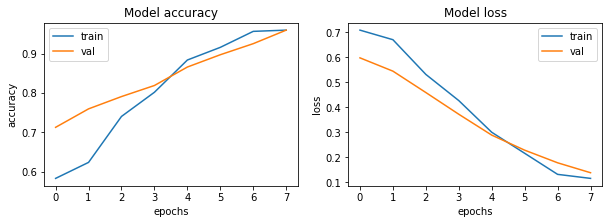

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_ds,steps=int(20))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test results 
 Loss: 0.14734111726284027 
 Accuracy 0.9605633616447449


In [32]:
def download_and_predict(filename):
    # download and save
    #os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = my_model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

67.48% 	 dirty
32.52% 	 clean


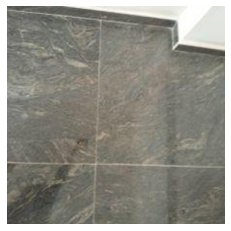

In [33]:
download_and_predict("/content/drive/MyDrive/ADA_Project/test1/Clean_(24).jpg")

81.80% 	 dirty
18.20% 	 clean


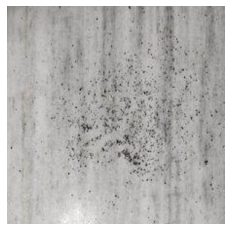

In [34]:
download_and_predict("/content/drive/MyDrive/ADA_Project/test1/Dirty_(312).jpg")


60.23% 	 clean
39.77% 	 dirty


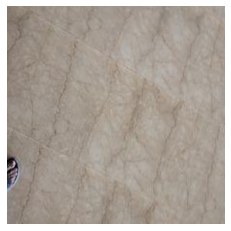

In [35]:
download_and_predict("/content/drive/MyDrive/ADA_Project/test1/Clean_(137).jpg")


82.30% 	 clean
17.70% 	 dirty


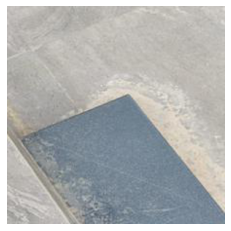

In [36]:
download_and_predict("/content/drive/MyDrive/ADA_Project/test1/image.jpg")


98.92% 	 dirty
1.08% 	 clean


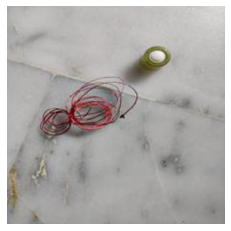

In [37]:
download_and_predict("/content/drive/MyDrive/ADA_Project/test1/dir.jpg")


54.17% 	 dirty
45.83% 	 clean


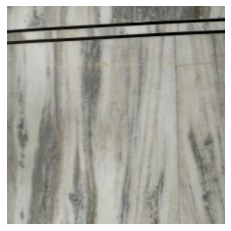

In [38]:
download_and_predict("/content/drive/MyDrive/ADA_Project/test1/Clean_(193).jpg")

In [ ]:
!ls

data   data_aug       floor_incept_weights.h5  my_model_inception.h5
data1  Floor_dataset  model.png		       test_1.jpg


In [40]:
%cd ..

/content/drive/MyDrive


In [41]:
!ls

'10 breeds.zip'
'19BCE7306_Lab_9 (1).ipynb'
'19BCI7014(10th-MarkSheet).pdf'
'19BCI7014 19BCI7039.pptx'
 19BCI7014.docx
'19BCI7014_Lab_13(RNN).ipynb'
' 19BCI7014_LAB7.ipynb'
 19BCI7014_Lab8.ipynb
'19BCI7068_LAB_7  .ipynb'
 1D_Array_Programs.rar
 8_lab_.ipynb
'Absentees List.xlsx'
 ADA_Project
'AI Ver3.0 (1).gdoc'
'AI Ver3.0.gdoc'
'AI Ver3.0.pdf'
'Assi-1(19BCI7014).pdf'
 beach.jpg
 brain_ct.jpg
 brain-tumor-mri-image-easy-codes-100-accuracy.ipynb
'B.Sai Subramanyam(19BCI7014) (1).pdf'
'B.Sai Subramanyam_19BCI7014 (1).zip'
'B.Sai Subramanyam-19BCI7014(Assignment).pdf'
' B.Sai Subramanyam(19BCI7014).docx'
'B.Sai Subramanyam(19BCI7014).pdf'
 Classroom
'Colab Notebooks'
'Copy of IMG_20211016_013704~3-01.jpg'
 CSE1006_FDA_PROJECT
'Digital assignment 1.pdf'
 DL
'Document from Sai.gdoc'
"'Double linked list_19BCI7014' .pdf"
 download.png
 elephant.jpeg
 EnjoySport.csv
 face
 flower1.jpg
 flowers
'Getting started.pdf'
 IMG_20190810_212953.pdf
 L2D1.csv
 L2D1.gsheet
 L2D2.csv
 LAB-11_19BCI7014.ip

In [42]:
%cd ..

/content/drive


In [44]:
!ls

MyDrive  Shareddrives


In [45]:
%cd ..

/content


In [46]:
my_model.save('my_model_resnet50.h5', overwrite=True) 
my_model.save_weights('floor_resnet50_weights.h5', overwrite=True)
print("Saved model to disk")

Saved model to disk
